### This notebook combines the two random samples

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord, match_coordinates_sky

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

##### both `random_field1` and `random_field2` are 2deg * 2deg

In [4]:
PREFIX = 'random_field1'
lsbg_cat = Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')

PREFIX = 'random_field2'
lsbg_cat = vstack([lsbg_cat, Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')])

PREFIX = 'random_field3'
lsbg_cat = vstack([lsbg_cat, Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')])
# lsbg_cat.sort('viz-id')
len(lsbg_cat)

2707

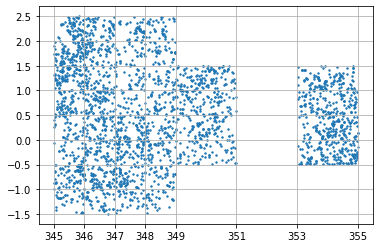

In [5]:
plt.scatter(lsbg_cat['ra'], lsbg_cat['dec'], s=2)
plt.grid()
plt.xticks([345, 346, 347, 348, 349, 351, 353, 355]);

In [6]:
total_area = 4 * 4 + 2 * 2 + 2 * 2
print('Total sky area [sqr deg]:', total_area)

Total sky area [sqr deg]: 24


Run `deploy_random.py` to run scarlet (both vanilla and spergel) on this sample.

---
### Analysis: make cuts to rule out junks

In [7]:
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='default', usetex=False)

In [8]:
method = 'vanilla'

PREFIX = 'random_field1'
lsbg_cat = Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')

PREFIX = 'random_field2'
lsbg_cat = vstack([lsbg_cat, Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')])

PREFIX = 'random_field3'
lsbg_cat = vstack([lsbg_cat, Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')])
lsbg_cat.sort('viz-id')
# len(lsbg_cat)

meas_cat = Table.read(f'./Catalog/random_field/{method}/lsbg_meas_{method}_nosegmap_all.fits')
meas_cat.sort('ID')

seg_meas_cat = Table.read(f'./Catalog/random_field/{method}/lsbg_meas_{method}_segmap_all.fits')
seg_meas_cat.sort('ID')

assert np.sum(meas_cat['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
assert np.sum(seg_meas_cat['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'

In [9]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [10]:
from sample_cuts import make_cuts_vanilla, make_cuts_spergel, post_process_cat_new

# of Candy: 395
# of Gal: 1412
# of Junk: 900


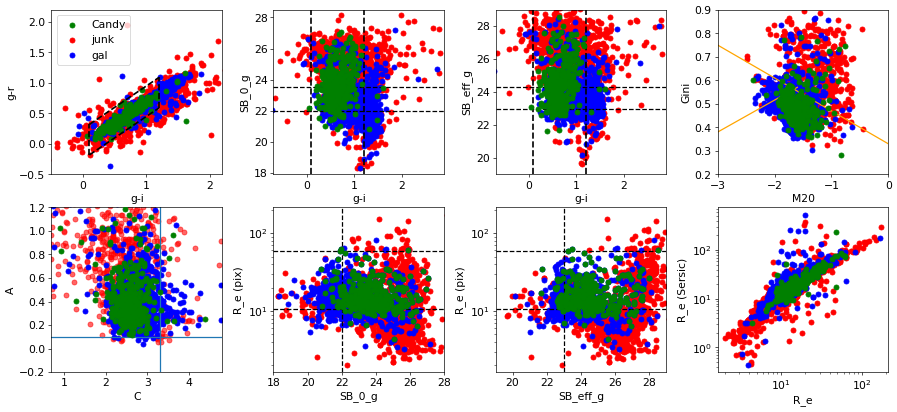

In [11]:
plot_measurement(lsbg_cat, meas_cat)

In [12]:
mask = make_cuts_vanilla(lsbg_cat, meas_cat)

Candy: 223
Gal: 315
Junk: 22


# of Candy: 223
# of Gal: 315
# of Junk: 22


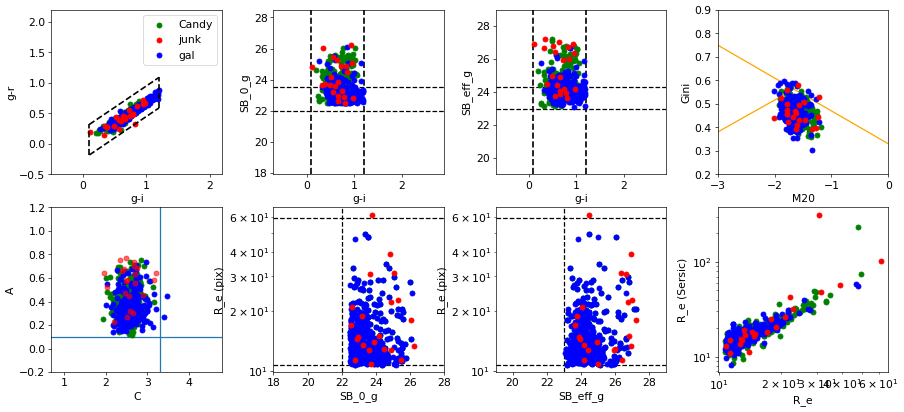

In [13]:
plot_measurement(lsbg_cat[mask], meas_cat[mask], gal_zorder=4, junk_zorder=5)

In [14]:
# Save this mask
np.save(f'./Catalog/random_field/lsbg_cuts_mask_{method}.npy', mask.data)

### Load Spergel catalog, apply mask, associate them with UDG hosts, apply UDG criteria

In [23]:
suffix = 'nosegmap'
method = 'spergel'

meas_cat = Table.read(f'./Catalog/random_field/{method}/lsbg_meas_{method}_{suffix}_all.fits')
meas_cat.sort('ID')
assert np.all(meas_cat['ID'] == lsbg_cat['viz-id']), "Two catalogs do not match!"
mask = np.load('./Catalog/random_field/lsbg_cuts_mask_vanilla.npy')

cuts_cat = hstack([lsbg_cat[mask], meas_cat[mask]])

# Additional step: remove large and small R_e in spergel
flag = make_cuts_spergel(cuts_cat)
cuts_cat = cuts_cat[flag]

print('Number of objs after junk cuts', len(cuts_cat))

Number of objs after junk cuts 517


In [24]:
### remove overlapping objects
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')

dist_mat = lsbg_coord[None, :].separation(lsbg_coord[:, None]).to(u.deg).value
np.fill_diagonal(dist_mat, 100)

if (dist_mat < (3 * u.arcsec).to(u.deg).value).sum() > 0:
    print('Have overlapping pairs:')
else:
    print('No overlapping objects')

# because dist_mat is symmetric, we set the lower half to a random large number (i.e., 100)
dist_mat[np.triu_indices(len(dist_mat), 0)] = 100
inds = np.vstack(np.where((dist_mat < (3 * u.arcsec).to(u.deg).value)))
print(len(inds.T))

Have overlapping pairs:
10


In [25]:
re_diff = (cuts_cat[inds[0]]['rhalf_spergel'] - cuts_cat[inds[1]]['rhalf_spergel']) * 0.168
# write to vis inspection
from sample_cuts import match_two_arrays
ind1 = cuts_cat[inds[0][np.abs(re_diff) >= 2]]['viz-id'].data
ind2 = cuts_cat[inds[1][np.abs(re_diff) >= 2]]['viz-id'].data
ind = np.vstack([ind1, ind2]).T.ravel()
cuts_cat[match_two_arrays(cuts_cat['viz-id'].data, ind)][['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/udg_spergel_overlapping.txt', 
    format='ascii', overwrite=True)
# https://tigress-web.princeton.edu/~jiaxuanl/galary/
# after viz inspect, we find remove anyone is fine

In [26]:
to_remove_ind = list(cuts_cat[inds[0]]['viz-id'].data)
cuts_cat = cuts_cat[~np.in1d(cuts_cat['viz-id'], to_remove_ind)]
print('Number of objs after removing overlappers:', len(cuts_cat))

Number of objs after removing overlappers: 508


# of Candy: 213
# of Gal: 281
# of Junk: 14


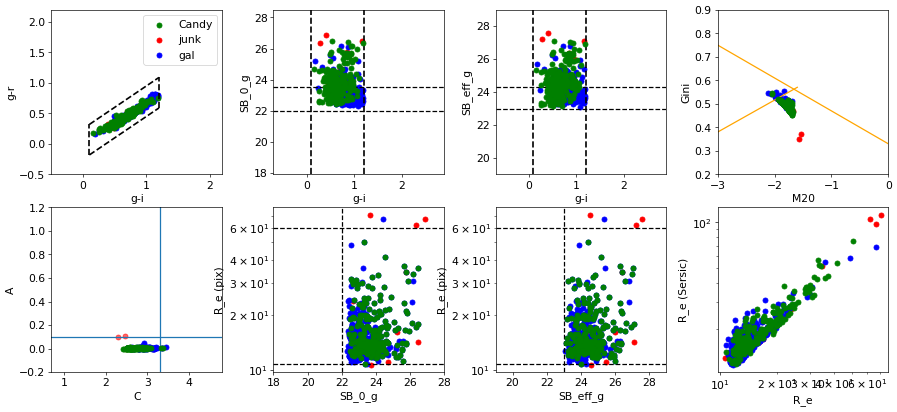

In [27]:
plot_measurement(cuts_cat, cuts_cat)#, gal_zorder=10)

In [28]:
cuts_cat.write('./Catalog/random_field/lsbg_after_cuts_spergel.fits', overwrite=True)

---
### Visual inspection

In [59]:
cuts_cat = Table.read('./Catalog/random_field/lsbg_after_cuts_spergel.fits')
len(cuts_cat)

508

In [60]:
udg_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.fits')
## Remove real UDGs from random fields
udg_coor = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
cuts_coor = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')
ind, sep, _ = match_coordinates_sky(cuts_coor, udg_coor)
print('Removed # of real MW-UDGs:', np.sum(sep < 1 * u.arcsec))
cuts_cat = cuts_cat[sep > 1 * u.arcsec]

Removed # of real MW-UDGs: 23


In [62]:
cuts_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/lsbg_random_field_spergel.txt', 
    format='ascii', overwrite=True)

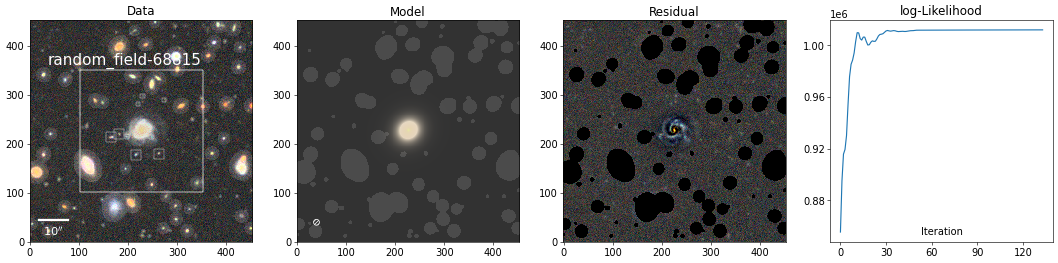

In [63]:
from PIL import Image
method = 'spergel'
Image.open(f'./Figure/random_field2/{method}/random_field-68815-zoomin-{method}.png')

In [64]:
votes = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/lsbg_random_field_spergel_votes.txt',
                   format='ascii')
flag = ~(votes['marked'] == 'true')
cuts_cat = cuts_cat[flag]
len(cuts_cat)

478

In [65]:
junk = (cuts_cat['bad_votes'] > cuts_cat['good_votes'])
candy = (cuts_cat['good_votes'] > cuts_cat['bad_votes']) & (
    cuts_cat['is_candy'] > cuts_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 193
# of Gal: 277
# of Junk: 8


In [66]:
cuts_cat.write(
    f'/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/lsbg_random_field_spergel_after_viz.fits', 
              overwrite=True)
cuts_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/lsbg_random_field_spergel_after_viz.txt', 
    format='ascii', overwrite=True)

---
### Random draws and select UDG sample

In [73]:
cuts_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/lsbg_random_field_spergel_after_viz.fits')

In [92]:
n_rep = 5
n_match = 20
for k in range(n_rep):
    # Randomly select lsbgs in the random fields
    inds = np.random.choice(np.arange(len(cuts_cat)), size=len(cuts_cat), replace=True)
    _cuts_cat = cuts_cat[inds]

    UDG_num = []
    for i in range(n_match):
        # Randomly match with UDG hosts
        inds = np.random.randint(0, len(udg_cat), len(_cuts_cat))
        _temp = hstack([_cuts_cat, 
                            udg_cat[inds][[key for key in udg_cat.colnames if 'host' in key]]])
        _temp = post_process_cat_new(_temp)
    
        ### UDGs
        flag = (_temp['rhalf_phys'] + _temp['rhalf_phys_err'] >= 1.5
           ) & (_temp['SB_eff_avg'][:, 0] + _temp['SB_eff_avg_err'][:, 0] >= 24.5)

        if i == 0 and k == 0:
            fake_udg_cat = _temp[flag]
        else:
            fake_udg_cat = vstack([fake_udg_cat, _temp[flag]])
        
        UDG_num.append(np.sum(flag))

print(np.mean(UDG_num) / len(_cuts_cat) * 100)

19.595744680851062


In [93]:
np.mean(UDG_num) / 24 * 31.6 / len(udg_cat), np.std(UDG_num) / 24 * 31.6 / len(udg_cat)

(0.28600235849056604, 0.018263552834120702)

In [94]:
print(np.std(UDG_num) / len(_cuts_cat) * 100)

1.251346038513414


(array([ 278., 1360., 3840.,  558.,  513.,  386.,  789.,  460.,  529.,
         240.]),
 array([0.05254509, 0.12770468, 0.20286428, 0.27802388, 0.35318347,
        0.42834307, 0.50350267, 0.57866227, 0.65382186, 0.72898146,
        0.80414106]),
 <BarContainer object of 10 artists>)

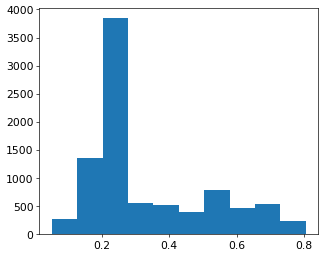

In [76]:
plt.hist(fake_udg_cat['completeness'])

In [95]:
fake_udg_cat.write('./Catalog/random_field/fake_udg_cat_220603.fits', overwrite=True)

In [96]:
_, ind = np.unique(fake_udg_cat['viz-id'], return_index=True)

In [97]:
fake_udg_cat[ind][['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/fake_udgs.txt', 
    format='ascii', overwrite=True)

## Size distribution

In [145]:
from sample_cuts import moving_binned_statistic

In [165]:
total_area

24

In [154]:
n_bins = 8
range_0 = np.array([np.log10(1.5), np.log10(8)])

In [158]:
output, cen = moving_binned_statistic(np.log10(fake_udg_cat['rhalf_phys']), 
                                      np.log10(fake_udg_cat['rhalf_phys']), 
                                      x_err=fake_udg_cat['rhalf_phys_err'],
                                      bins=n_bins, range_=range_0, 
                                      statistic='count', n_slide=20)
n_cen = np.nanmean(output, axis=0) / (n_rep * n_match) / total_area
n_std = np.nanstd(output, axis=0) / (n_rep * n_match) / total_area

<ErrorbarContainer object of 3 artists>

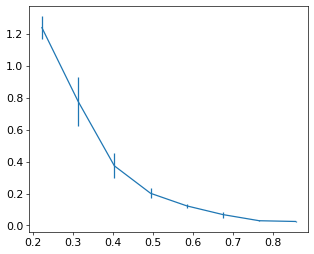

In [159]:
plt.errorbar(cen, n_cen, yerr=n_std)

In [160]:
np.save('./Catalog/completeness/bkg_size.npy', 
        np.vstack([cen, n_cen, n_std]))

---

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

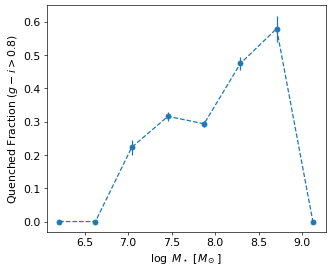

In [113]:
from scipy.stats import binned_statistic
red = ((fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]) > 0.8)
quench_frac, edges, _ = binned_statistic(fake_udg_cat['log_m_star'], red.astype(float), 
                                             statistic='mean', range=(6, 11), bins=12)
num, edges, _ = binned_statistic(fake_udg_cat['log_m_star'], red.astype(float), 
                                             statistic='count', range=(6, 11), bins=12)

plt.errorbar((edges[:-1] + edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [280]:
fake_udg_cat.write('./Catalog/random_test.fits')

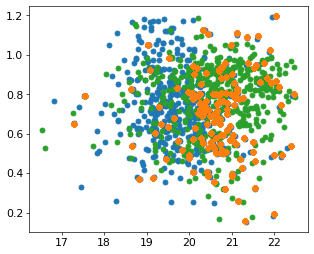

In [117]:
plt.scatter(cuts_cat['mag'][:, 1], (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 2]))

plt.scatter(fake_udg_cat['mag'][:, 1], (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter(udg_cat['mag'][:, 1], (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

In [158]:
# vdBurg+17 method
fake_udg_cat['weights'] = 8 / 27.8 / 100
udg_cat['weights'] = 1.0

for src in fake_udg_cat:
    _x, _y = src['mag'][1], (src['mag'][0] - src['mag'][2])
    arg = np.argmin((_x - udg_cat['mag'][:, 1].data)**2 + (_y - (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]).data)**2)
    udg_cat[arg]['weights'] -= src['weights']
    
plt.hist(udg_cat['weights'].data)

(array([  1.,   2.,   0.,   5.,   4.,   3.,   5.,   8.,   9., 315.]),
 array([0.42158273, 0.47942446, 0.53726619, 0.59510791, 0.65294964,
        0.71079137, 0.76863309, 0.82647482, 0.88431655, 0.94215827,
        1.        ]),
 <BarContainer object of 10 artists>)

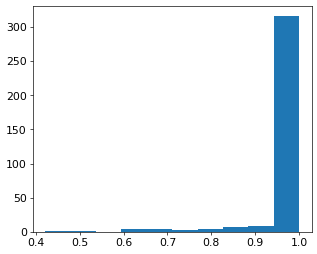

In [249]:
fake_udg_cat['weights'] = 8 / 27.8 / 100
udg_cat['weights'] = 1.0

for src in fake_udg_cat:
    _x, _y = src['C'], (src['mag'][0] - src['mag'][2])
    arg = np.argmin((_x - udg_cat['C'].data)**2 + (_y - (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]).data)**2)
    udg_cat[arg]['weights'] -= src['weights']
    
plt.hist(udg_cat['weights'].data)

In [251]:
udg_cat.write('./Catalog/nsa_test.fits', overwrite=True)

Text(0, 0.5, 'g-i')

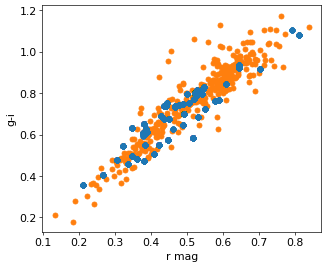

In [252]:
plt.scatter((fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 1]), 
            (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter((udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]), 
            (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

plt.xlabel('r mag')
plt.ylabel('g-i')

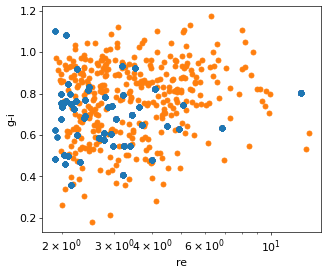

In [272]:
plt.scatter((fake_udg_cat['rhalf_spergel']), 
            (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter((udg_cat['rhalf_spergel']), 
            (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

plt.xlabel('re')
plt.ylabel('g-i')

plt.xscale('log')

Text(0, 0.5, 'g-i')

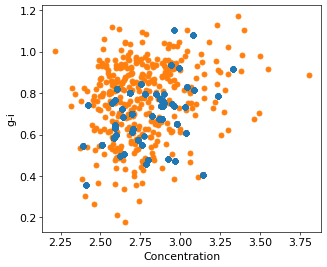

In [254]:
plt.scatter(fake_udg_cat['C'], 
            (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter(udg_cat['C'], 
            (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

plt.xlabel('Concentration')
plt.ylabel('g-i')

In [ ]:
plt.scatter(fake_udg_cat['C'], 
            (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]), zorder=10)

plt.scatter(udg_cat['C'], 
            (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]))

plt.xlabel('Concentration')
plt.ylabel('g-i')

In [101]:
np.mean(np.array(UDG_num) / 8)

4.10625

In [97]:
np.mean(np.array(UDG_num) / 8 * 27 / 352)

0.31496803977272725

In [98]:
np.array(UDG_num) / len(cuts_cat)

array([0.2137931 , 0.24137931, 0.2       , 0.20689655, 0.2137931 ,
       0.2137931 , 0.23448276, 0.24827586, 0.2137931 , 0.2       ,
       0.23448276, 0.22758621, 0.25517241, 0.25517241, 0.26206897,
       0.2137931 , 0.26206897, 0.17931034, 0.20689655, 0.24827586])

In [255]:
gi_color = fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]

(array([158., 229., 348., 621., 392., 809., 295., 108.,   0.,  44.]),
 array([0.35841065, 0.43304535, 0.50768005, 0.58231475, 0.65694945,
        0.73158415, 0.80621885, 0.88085355, 0.95548824, 1.03012294,
        1.10475764]),
 <BarContainer object of 10 artists>)

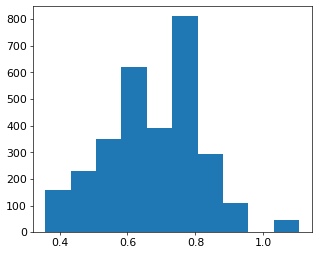

In [256]:
plt.hist(gi_color)

In [92]:
ids = np.unique(fake_udg_cat['viz-id']).data

In [93]:
lsbg_cat[np.in1d(lsbg_cat['viz-id'], ids)][['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/lsbg_random_field_spergel_udg.txt', 
    format='ascii')

(18.0, 29.0)

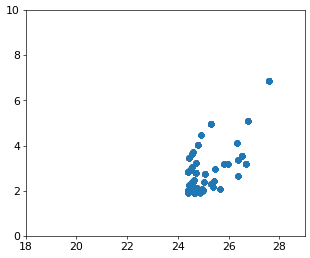

In [94]:
plt.scatter(fake_udg_cat['SB_eff_avg_g'], fake_udg_cat['rhalf_spergel'])

plt.ylim(0, 10)
plt.xlim(18, 29)

### Mass-size

In [56]:
ang_diam_dist = fake_udg_cat['host_ang_diam_dist'].data
fake_udg_cat['abs_mag'] = fake_udg_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # griz

### Absolute magnitude ###
g_mag = fake_udg_cat['mag'][:, 0].data
g_abs = fake_udg_cat['abs_mag'][:, 0].data
# Correct for measurement error
with open('./Catalog/completeness/mag_g_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
g_abs += f_med(g_mag)
g_abs_std = f_std(g_mag)

### Color
gr_color = (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 1]).data
with open('./Catalog/completeness/gr_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
gr_color += f_med(gr_color)
gr_color_std = f_std(gr_color)

gi_color = (fake_udg_cat['mag'][:, 0] - fake_udg_cat['mag'][:, 2]).data
with open('./Catalog/completeness/gi_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
gi_color += f_med(gi_color)
gi_color_std = f_std(gi_color)

# average over g-i and g-r results
log_ML_g = np.array([1.297 * gi_color - 0.855, 
                     1.774 * gr_color - 0.783]).mean(axis=0)

log_ML_g_std = np.sqrt((1.297 * gi_color_std)**2 + (1.774 * gr_color_std)**2) / 2

M_g = -0.4 * (g_abs - 5.03) + log_ML_g
M_g_std = np.sqrt((0.4 * g_abs_std)**2 + log_ML_g_std**2)

# fake_udg_cat['log_m_star'] = M_g
# fake_udg_cat['g_abs'] = g_abs

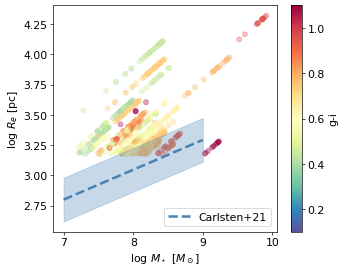

In [57]:
import matplotlib
from matplotlib.colors import Normalize

norm = Normalize(vmin=0.1, vmax=1.1)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(gi_color)

yerrs = np.array([np.log10(R_e_phys + R_e_phys_std) - np.log10(R_e_phys), 
         np.log10(R_e_phys) - np.log10(R_e_phys - R_e_phys_std)])

sct = plt.scatter(
        M_g, 
        np.log10(R_e_phys) + 3, # in pc
#         xerr=M_g_std[i],
#         yerr=yerrs[:, i].reshape(-1, 1),
        color=_colors,
#         fmt='o', 
        alpha=0.35)
plt.colorbar(sm, label='g-i')

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ R_{e}\ [\rm pc]$')
plt.legend(loc='lower right')

# plt.xlim(6.8, 9.2)

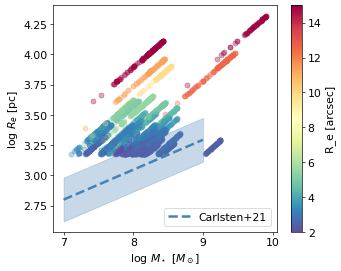

In [43]:
import matplotlib
from matplotlib.colors import Normalize

norm = Normalize(vmin=2, vmax=15)
cmap = matplotlib.cm.Spectral_r
sm = matplotlib.cm.ScalarMappable(norm, cmap)
sm.set_array([])
_colors = sm.to_rgba(R_e)

yerrs = np.array([np.log10(R_e_phys + R_e_phys_std) - np.log10(R_e_phys), 
         np.log10(R_e_phys) - np.log10(R_e_phys - R_e_phys_std)])

for i,_ in enumerate(M_g):
    sct = plt.scatter(
        M_g[i], 
        np.log10(R_e_phys[i]) + 3, # in pc
#         xerr=M_g_std[i],
#         yerr=yerrs[:, i].reshape(-1, 1),
        color=_colors[i],
#         fmt='o', 
        alpha=0.35)
plt.colorbar(sm, label='R_e [arcsec]')

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ R_{e}\ [\rm pc]$')
plt.legend(loc='lower right')

# plt.xlim(6.8, 9.2)

In [54]:
cuts_cat[np.in1d(cuts_cat['viz-id'], np.unique(fake_udg_cat['viz-id']))][['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/random_fields_fake_gal.txt', 
    format='ascii')

In [55]:
cuts_cat[np.in1d(cuts_cat['viz-id'], np.unique(fake_udg_cat[(gi_color > 0.8) & (M_g > 8)]['viz-id']))][['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/random_fields/random_fields_fake_gal_red.txt', 
    format='ascii')

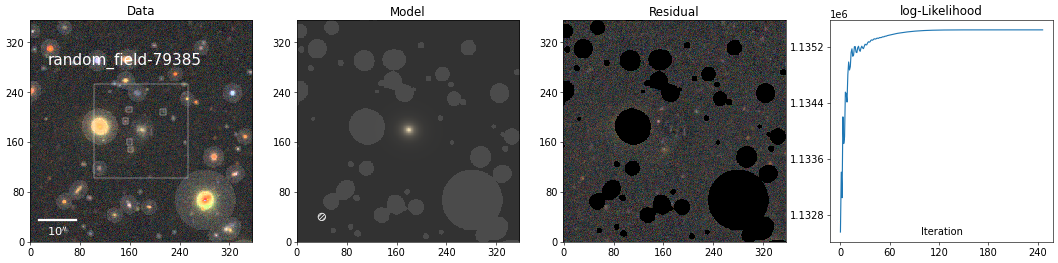

In [294]:
method = 'spergel'
Image.open(f'./Figure/random_field1/{method}/random_field-79385-zoomin-{method}.png')

24804: real lsbg
32510: bkg lsbg
41956: bkg?
59542: bkg spiral
66612: bkg spiral
70057: bkg spiral
70283: bkg spiral
71888: bkg spiral
79385: bkg

In [58]:
from scipy.stats import binned_statistic
red = (gi_color > 0.7)
quench_frac, edges, _ = binned_statistic(M_g, red.astype(float), 
                                             statistic='mean', range=(6, 11), bins=12)
num, edges, _ = binned_statistic(M_g, red.astype(float), 
                                             statistic='count', range=(6, 11), bins=12)

plt.errorbar((edges[:-1] + edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [25]:
inds = np.random.randint(0, len(cuts_cat), 80)
cuts_cat = cuts_cat[inds]

In [26]:
percentages = []
errors = []

In [27]:
_udg_cat_ind = []
for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_wavelet.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(100):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.5) & (cuts_cat['SB_0'][:, 0] >= 24.)
        # & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        UDG_num.append(np.sum(flag))
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)

In [29]:
print('Background percentage (%):', 
      round(np.mean(percentages), 2), 
      '+-', round(np.std(percentages), 2), 
      '+-', round(np.mean(errors), 2))

Background percentage (%): 21.64 +- 2.46 +- 1.59


In [31]:
len(udg_cat) * 0.8

337.6

Text(0, 0.5, '$\\log\\ r_{e}^{\\rm circ}\\ [\\rm pc]$')

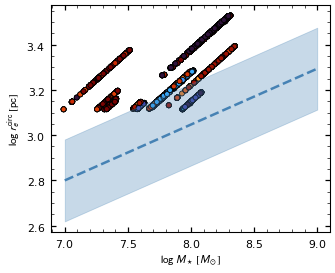

In [194]:
_udg_cat_ind = []
fig, ax = plt.subplots()

for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(50):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        cuts_cat['V_abs'] = V_abs
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        UDG_num.append(np.sum(flag))
        
        _udg_cat = cuts_cat[flag]
        sct = plt.scatter(_udg_cat['log_m_star'], 
                    np.log10(_udg_cat['rhalf_circularized_phys']) + 3, 
                    c=_udg_cat['viz-id'],#_udg_cat['mag'][:, 0] - _udg_cat['mag'][:, 2],
                    label='UDGs')
        
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)
    
x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
#plt.legend(loc='lower right')

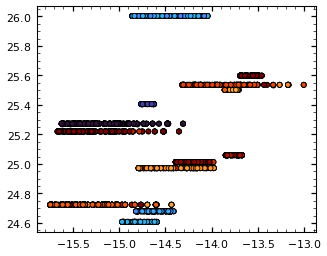

In [204]:
_udg_cat_ind = []
fig, ax = plt.subplots()

for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(50):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        cuts_cat['V_abs'] = V_abs
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        #print(np.sum(flag))
        UDG_num.append(np.sum(flag))
        
        _udg_cat = cuts_cat[flag]
        sct = plt.scatter(_udg_cat['V_abs'], 
                  _udg_cat['SB_0'][:, 0], 
            c=_udg_cat['viz-id'])
        
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)


In [197]:
cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')

In [202]:
(cuts_cat['SB_eff_avg'][:, 0] >= 25.2) == (cuts_cat['SB_0'][:, 0] >= 24.5)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

(-12.0, -16.0)

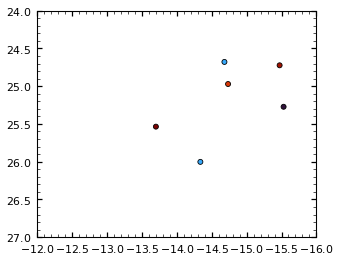

In [195]:
sct = plt.scatter(_udg_cat['V_abs'], 
                  _udg_cat['SB_0'][:, 0], 
            c=_udg_cat['viz-id'])
aa
plt.ylim(27, 24)
plt.xlim(-12, -16)

In [193]:
print('Background percentage (%):', 
      round(np.mean(percentages), 2), 
      '+-', round(np.std(percentages), 2), 
      '+-', round(np.mean(errors), 2))

Background percentage (%): 5.73 +- 1.62 +- 1.06


In [176]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

In [7]:
from PIL import Image

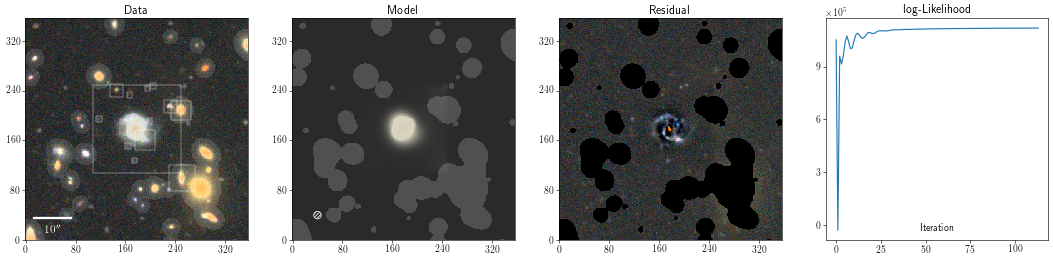

In [8]:
Image.open('./Figure/random_field/random_field-11-zoomin-wavelet.png')

In [14]:
# Table.read('/tigress/jiaxuanl/Data/HSC/LSBG/Catalog/random_field/random_field_cutout_cat_random_field.fits')['viz-id']

In [10]:
Table.read('./Catalog/random_field1/vanilla/_lsbg_meas_vanilla_vanilla_0_1_nosegmap.fits')a

ID,flux [4],mag [4],flux_circ [4],flux_ellip [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],SB_eff_avg [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,rhalf_circularized,rhalf_spergel,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11,1351.8564453125 .. 3487.21484375,19.172672271728516 .. 18.143802642822266,1308.3974609375 .. 3375.109130859375,1308.7745361328125 .. 3376.081787109375,22.057159423828125 .. 21.028289794921875,23.75481414794922 .. 22.72594451904297,23.795576095581055 .. 22.766706466674805,23.157758712768555 .. 22.128889083862305,250.9280764390494,250.31200835161735,247.84458343528684,249.35892740296617,0.2627317415374718,0.2681625988348981,0.7042938575883512,0.6845855749870591,14.969643253206927,17.363268958571386,14.853841756690928,nan,7.123019004405474,14.445893005841318,23.525865570971977,0.477429047836379,-1.7585686830411758,-0.3780381158623891,-0.09878628958470825,2.594407540178203,0.23165650963765888,0.4406529161418085,0.6764057754508804,0.025912737094352562,1.249105131358901,16.270650856760298,0.1099793835258732,0.513833908985502,247.41737314226205,249.23824072880618,0.4640229047230237,0.0,0.0
